# Type 2: the metacognitive stage

In [13]:
import remeta
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The main goal of ReMeta is making inferences about metacognitive noise and biases. Metacognitive noise is any noise that occurs after the computation of the type 1 decision variable ($y$). Metacognitive biases describe under- and overconfidence.

As shown in the below diagram, this fundamentally requires a decision by the modeler at which point in the hierarchy such sources of noise and bias may occur.

:::{figure} img/model_type2.png
:align: center
:width: 90%
:::

ReMeta considers three sources of metacognitive noise:

|  | How to enable |What it is|Reference|
|----------|----------|----------|----------|
| Noisy report (default)    | `cfg.type2_noise_type = 'report'`   | Noisy confidence report | @Shekhar2021 |
| Noisy readout    | `cfg.type2_noise_type = 'readout'`   | Noisy readout of type 1 evidence | @Guggenmos2022 |
| Noisy temperature     | `cfg.type2_noise_type = 'temperature'`   | Noisy estimate of one's own type 1 noise | @BoundySinger2022 |

At this point, these noise sources are mutually excluside, i.e. the modeler has to make an assumption about the dominant source of metacognitive noise (or do systematic testing).

ReMeta is fundamentally built on the assumption that observers computed as the probability $p(\text{correct})$ that the type 1 decision was correct, i.e.

$$
p(\text{correct}) = \Phi\left(\frac{z_2}{\sigma_1}\right)
$$

in case of normal type 1 noise and

$$
p(\text{correct}) = \frac{1}{2}\tanh\left(\frac{\pi}{2\sqrt{3}\sigma_1}z_2\right)
$$

in case of logistic type 1 noise.

Note that this assumption is required to compute metacognitive biases, as otherwise one would have to ask: under/overconfident _relative to what_?

In ReMeta, confidence $c$ is represented on a scale from 0, corresponding to $p(\text{correct})=0.5$ (i.e. guessing), to 1, corresponding to $p(\text{correct})=1$. Mathematically this is a simple transformation:

$$
c = 2\,p(\text{correct}) - 1
$$

For this reason, confidence ratings should be passed as normalized values between 0 and 1 to ReMeta.

## Default parameters

### Type 2 noise

|Parameter|Symbol|How to enable|Default|Possible values|
|--|--|--|--|--|
|`type2_noise`|$\sigma_2$|`cfg.param_type2_noise.enable = 1`|`1`|`1`|

While the the nature of type 2 metacognitive noise is up to the researcher (`'report'`, `'readout'` or `'temperature'`), the type2 noise parameter cannot be disabled, as a probabilistic aspect is required for maximum likelihood estimation.

The difference between the three sources of metacognitive noise is not just conceptual. Each noise source has a clear computational signature, as seen below:

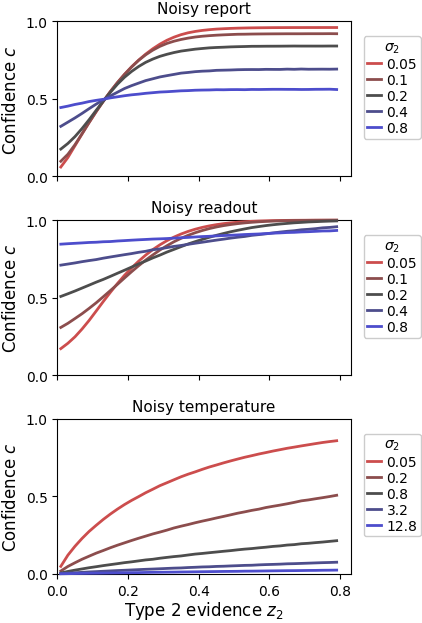

In [14]:
from IPython.display import Image, display
display(Image(filename='img/type2_parameters_noise.png'))

In all three cases, higher metacognitive noise ($\sigma_2$) leads to a shallower relationship between type 1 evidence $z_1$ and confidence $c$, i.e. to reduced metacognitive sensitivity. Howvever, for very high metacognitive noise, the noisy-report model predicts average confidence for all type 1 evidence, the noise-readout model maximum confidence, and the noisy-temperature model minimal confidence.

Which noise type is dominant for human observers is currently unknown. For an individual study, we recommend checking out the type 2 likelihod for each of the architectures to make an informed decision.

#### Type 2 noise distribution

Likewise unknown is the precise distributional nature of metacognitive noise. In ReMeta, the distribution can be set via

```python
cfg.param_type2_noise.distribution = '...'
```

Available options:

|`cfg.type2_noise_type`|Default|Available choices for `cfg.type2_noise_dist`|
|----|----|----|
|`'report'`|`'beta_mode'`|`'beta_mean_std', 'beta_mode_std', 'beta_mode', 'truncated_normal_mode_std', 'truncated_normal_mode', 'truncated_gumbel_mode_std', 'truncated_gumbel_mode', 'truncated_lognormal_mode_std', 'truncated_lognorm', 'truncated_lognormal_mode', 'truncated_lognormal_mean'`|
|`'readout'` / `'temperature'`|`'lognormal_mode_std'`|`'lognormal_median_std', 'lognormal_mean', 'lognormal_mode', 'lognormal_mode_std', 'lognormal_mean_std','gamma_mode_std', 'gamma_mean_std', 'gamma_mean', 'gamma_mode', 'gamma_mean_cv','betaprime_mean_std','truncated_normal_mode_std', 'truncated_normal_mode','truncated_gumbel_mode_std', 'truncated_gumbel_mode'`|

The suffices `_mode` and `_mean` indicate a parameterization of the distribution which preserves the mode and mean, respectively. The suffices `_std` and `_cv` indicate a parameterization such that `type2_noise` (i.e. $\sigma_2$) corresponds to the standard deviation and the coefficient of variation, respectively.

A paper is still to be written about the evidence and validity of different metacognitive noise distributions. For now, the default choices (`beta_mode` / `lognormal_mode_std`) in ReMeta are motivated by the following criteria:

- Good performance on test datasets (not yet published)
- External validity: type 2 noise parameter correlates well with IQ (not yet published)
- Analytical parameterization possible (=computationally efficient)
- Parameter `type2_noise` corresponds roughly to the standard deviation of the noise distribution, for ease of interpretability across models.
- Previous evidence in favor of the lognormal distribution as opposed to e.g. a Gamma distribution [@Shekhar2021;@BoundySinger2022].

In [15]:
import remeta
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The default distribution for noisy-report models `'beta_mode'` follows the standard mode-concentration parameterization of the Beta distribution:

:::{math}
:enumerated: false
x=\text{confidence }c;\quad\sigma_2=\text{metacognitive noise}
:::

$$
\text{Concentration:}\quad\kappa
=
2 + \frac{x(1-x)}{\sigma_2^2}
$$

$$
X \sim \mathrm{Beta}(1 + x(\kappa - 2),1 + (1-x)(\kappa - 2))
$$

In this parameterization, $\sigma_2$ is not exactly the standard deviation of the Beta distribution, but a reasonable approximation.

The default distribution for noise-readout/temperature models `'lognormal_mode_std'` is an exact parameterization in terms of standard deviation and mode:

:::{math}
:enumerated: false
\text{Noisy-readout:}\;\; x=\text{type 1 evidence }z_1
:::

:::{math}
:enumerated: false
\text{Noisy-temperature:}\;\; x=\text{type 1 noise }\sigma_1
:::

:::{math}
:enumerated: false
\sigma_2=\text{metacognitive noise}
:::

$$
a \;=\; \frac{\sigma_2^{2}}{x^{2}}
$$

$$
\Delta \;=\; \sqrt{3}\,\sqrt{256a^{3}+27a^{2}} \;-\; 9a
$$

$$
R \;=\;
-\frac{16\left(\frac{2}{3}\right)^{1/3}a}{\Delta^{1/3}}
+
2\left(\frac{2}{3}\right)^{2/3}\Delta^{1/3}
+
1
$$

$$
S \;=\;
\frac{4\left(\frac{2}{3}\right)^{1/3}a}{\Delta^{1/3}}
-
\frac{\Delta^{1/3}}{2^{1/3}3^{2/3}}
+
\frac{1}{2\sqrt{R}}
+
\frac{1}{2}
$$

$$
T \;=\; \frac{1}{4}\sqrt{R} \;+\; \frac{1}{2}\sqrt{S} \;+\; \frac{1}{4}
$$


$$
X \sim \mathrm{LogNormal}\big(\ln(x\,T),\,\ln T\big)
$$

:::{math}
:enumerated: false
\text{(i.e. }\ln(x\,T)\text{ and }\ln T\text{ are the mean and variance}\\\text{of the underlying normal distribution)}
:::

:::{figure} img/type2_noise_dist.png
:align: center

Type 2 noise distributions with $\sigma_2=0.1.$
:::

### Type 2 criteria

|Parameter|Symbol|How to enable|Default|Possible values|
|--|--|--|--|--|
|`type2_criteria`|$\gamma^i$|`cfg.param_type2_criteria.enable = <ncriteria>`|`3`|`0`, `<ncriteria>`|

The majority of confidence scales used in the field are based on a discrete scales, e.g. 1=very unsure, 2=unsure, 3=sure, 4=very sure. Thus, participants in such studies need to apply criteria to map a (possibly) continuous internal estimate to a finite number of response options. 

In ReMeta, such criteria are fitted at the last stage of the process. Specifically, it is assumed that observers have a continuous internal estimate of confidence (range 0-1) and apply a set of criteria $\gamma^1, \dots, \gamma^n$ to this internal estimate.

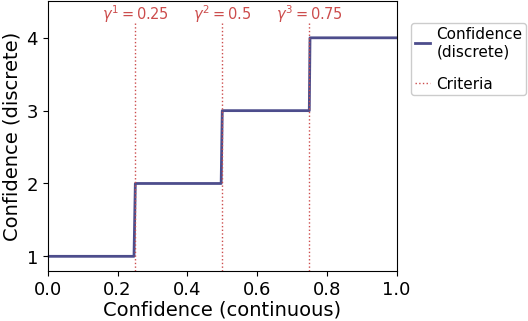

In [16]:
display(Image(filename='img/type2_parameters_criteria.png'))

The number of fitted confidence criteria is set via `cfg.param_type2_criteria.enable = <ncriteria>`, where `<ncriteria>` should be the number of available confidence ratings minus 1. The default is `3`, i.e. corresponding to a 4-point confidence scale.

By default, it is recommended to fit confidence criteria even for continuous confidence scales. Even for continuous scales, observers tend to have idiosyncratic ways of using different sections of the scale and this is often best accounted for through confidence criteria. For continuous scales, we recommend setting `cfg.param_type2_criteria.enable` to `3` or `4`.

#### Criterion and confidence bias

If confidence data are fitted with `type2_criteria` enabled, ReMeta will compute an average criterion bias which could be considered an estimate of the overall metacognitive bias. 

As an example, let's generate data in which each of the observers three confidence criteria [0.35, 0.5, 0.85] is shifted by 0.1 from Bayes-optimal confidence criteria [0.25, 0.5, 0.75].

In [17]:
params = dict(type1_noise=0.5, type1_bias=0, type2_noise=0.25, type2_criteria=[0.35, 0.6, 0.85])
np.random.seed(0)
sim = remeta.simulate(params=params)

----------------------------------
..Generative model:
    Type 1 noise distribution: normal
    Type 2 noise type: report
    Type 2 noise distribution: beta_mode
..Generative parameters:
    type1_noise: 0.5
    type1_bias: 0
    type2_noise: 0.25
    type2_criteria: [0.35 0.6  0.85]
        [extra] Criterion bias: 0.1000
        [extra] Criterion-based confidence bias: -0.1000
..Descriptive statistics:
    No. subjects: 1
    No. samples: 1000
    Accuracy: 83.2% correct
    d': 1.9
    Choice bias: -0.6%
    Confidence: 0.44
    M-Ratio: 0.09
    AUROC2: 0.53
----------------------------------


The red line below indicates the new mapping from internal (continuous) confidence to reported (discrete) confidence, relative to the Bayes-optimal mapping (blue line):

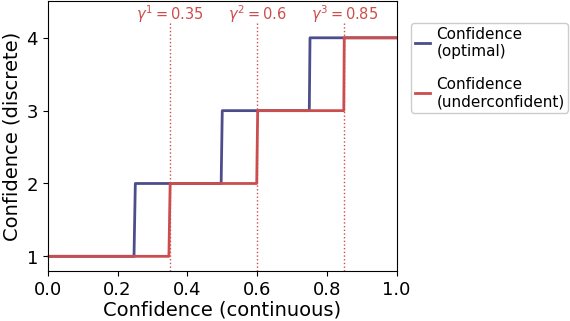

In [18]:
display(Image(filename='img/type2_parameters_criteria_underconfident.png'))

Positive criterion shifts are reflected in underconfident confidence reports, since higher internal confidence is required for each discrete confidence rating.

We now fit ReMeta to this dataset (using default settings, i.e. no `remeta.Configuration` is required, though we pass the true parameters for reference).

In [19]:
rem = remeta.ReMeta(true_params=params)
rem.fit(sim.stimuli, sim.choices, sim.confidence)
result = rem.summary()

Dataset characteristics:
    No. subjects: 1
    No. samples: 1000
    Accuracy: 83.2% correct
    d': 1.925
    Choice bias: -0.6%
    Mean confidence: 0.444 (min: 0.125, max: 0.875)

+++ Type 1 level +++
  Subject-level estimation (MLE)
    .. finished (0.1 secs).
  Final report
    Parameters estimates (subject-level fit)
        [subject] type1_noise: 0.483 ± 0.024 (true: 0.500)
        [subject] type1_bias: -0.017 ± 0.025 (true: 0.000)
    [subject] Log-likelihood: -386.82 (per sample: -0.3868)
    [subject] Fitting time: 0.08 secs
    Log-likelihood using true params: -387.27 (per sample: -0.3873)
Type 1 level finished

+++ Type 2 level +++
  Subject-level estimation (MLE)
    .. finished (28.8 secs).
  Final report
    Parameters estimates (subject-level fit)
        [subject] type2_noise: 0.508 ± 0.154 (true: 0.250)
        [subject] type2_criteria: [0.312 ± 0.022, 0.588 ± 0.015, 0.862 ± 0.012] (true: [0.350, 0.600, 0.850])
            [extra] type2_criteria_bias: 0.099 ± 0.009

If type 2 criteria are fitted, the ReMeta summary contains a key `'type2_criteria_bias'` in `result.params_extra` which reflects just that:

In [20]:
print(f"Criterion bias: {result.params_extra['type2_criteria_bias']:.3f}")

Criterion bias: 0.099


Thus the criterion bias was estimated to be +0.089 (ground truth was +0.1). The confidence bias is just the negative of the criterion bias and is also part of `params_extra`:

In [21]:
print(f"Confidence bias: {result.params_extra['type2_criteria_confidence_bias']:.3f}")

Confidence bias: -0.099


Negative and positive confidence biases correspond to under- and overconfident observers, respectively.

In ReMeta, the type 2 criterion bias is computed as a weighted average deviation of estimated criteria $\hat{\boldsymbol{\gamma}}$ from Bayes-optimal criteria $\boldsymbol{\gamma}^\text{bayes}$. The weights are the uncertainty estimates of each criterion, such that more reliabily estimated criteria contribute stronger to the bias computation. In practise, we use the full covariance matrix for this weighted bias to also consider the correlation between criterion uncertainties:

$$
\text{criterion bias}
=
\frac{
\mathbf{1}^\top \Sigma_{\gamma}^{-1} \left( \hat{\boldsymbol{\gamma}} - \boldsymbol{\gamma}^\text{bayes} \right)}{\mathbf{1}^\top \Sigma_{\gamma}^{-1} \mathbf{1}}
$$

where $\Sigma_{\gamma}^{-1}$ is the inverse sampling covariance matrix of the criteria.

**However, there's a catch...**

While computing a confidence bias in this way serves for a first approximation, these bias estimates are post-hoc, i.e. they are not part of the process model and thus are likely (sic) biased.

This is a real dilemma in confidence modeling: human participants clearly apply idiosyncratic confidence criteria in their responses and those should be modeled; on the other hand, modeling those criteria makes an estimation of metacognitive biases very challenging.

The two parameters described below (`type2_evidence_bias` and `type2_confidence_bias`) make an attempt at incorporating bias parameters within the process model.

## Additional parameters

### Metacognitive evidence bias

|Parameter|Symbol|How to enable|Default|Possible values|
|--|--|--|--|--|
|`type2_evidence_bias`| $\varphi_2$|`cfg.type2_evidence_bias.enable = 1`|`0`|`0`, `1`|

Type 2 criteria account for metacognitive biases that occur at the level of the confidence *report*, i.e. when observers map an internal sense of confidence to an external confidence scale. The idea of a metacognitive evidene bias $\varphi_2$ is that biases may also occur at an earlier stage - specifically for the internal representation of *metacognitive evidence* $z_2$, which is algorithmically reflected as follows (assuming normal type 1 noise):

$$
p(\text{correct}) = \Phi\left(\frac{\varphi_2 z_2}{\sigma_1}\right)
$$

The effect of $\phi_2$ on confidence is shown in the figure below.

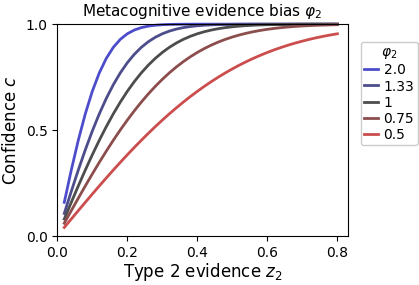

In [22]:
display(Image(filename='img/type2_parameters_evidence_bias.png'))

In theory, the metacognitive evidence parameter $\varphi_2$ is separable from the effects of type 2 criteria $\gamma_i$; in practice — with limited sample size — they might trade of each other.

### Metacognitive confidence bias

|Parameter|Symbol|How to enable|Default|Possible values|
|--|--|--|--|--|
|`type2_confidence_bias`| $\alpha_2$|`cfg.type2_confidence_bias.enable = 1`|`0`|`0`, `1`|

It seems tempting to model a metacognitive bias as a parameter that systematically affects all confidence criteria. For instance, consistent withe notion of an additive and multiplicative criteriorn bias above, one could think of describing metacognitive biases as a parametric deviation from Bayes-optimal criteria (e.g. $a\gamma_i^\text{bayes} + b$). Indeed, the evidence bias $\varphi_2$ above plays a role similar to $a$.

Additive shifts, in turn, are always tricky, since they need to be accompanied by clipping (e.g., neither evidence nor confidence can be below 0). ReMeta offers one additional metacognitive bias parameter that circumvents clipping issues: the *confidence bias* $\alpha_2$: 

$$
p(\text{correct}) = \left(\Phi\Big(\frac{z_2}{\sigma_1}\Big)\right)^{1/\alpha_2}
$$

$\alpha_2$ is a power-law parameter which ensures that confidence remains between 0 and 1. Such a parameter has little biological plausibility, but it is mathematically convenient. To some *very* rough approximation it resembles an additive shift, with appropriate asymptotic behavior at the confidence bounds 0 and 1.

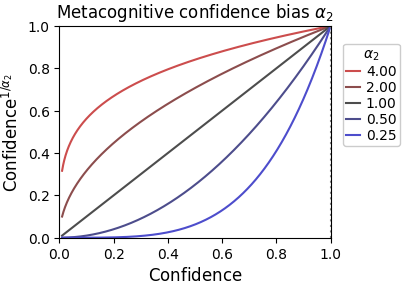

In [23]:
display(Image(filename='img/type2_parameters_confidence_bias_trans2.png'))

The computational signature of $\alpha_2$ is clearly distinguishable from the evidence bias $\varphi_2$:

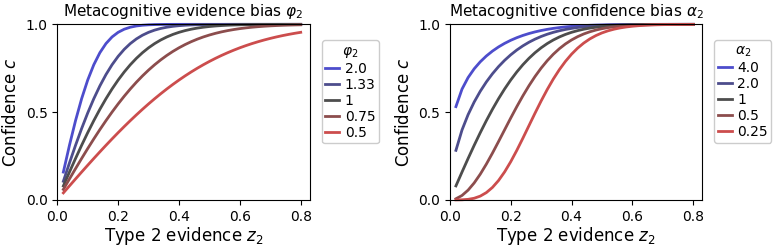

In [24]:
display(Image(filename='img/type2_parameters_biases.png'))

The parameters $\varphi_2$ and $\alpha_2$ are thus likely distinguishable in a parameter recovery analysis. Nevertheless, they have little empirical validation and may not work well with simultaneous confidence criteria. Fot this reason, $\varphi_2$ and $\alpha_2$ are disabled by default.